In [8]:
import tensorflow as tf
from keras import layers, metrics
from keras import losses
import numpy as np
import util
import time
from random import shuffle

# other classifiers for comparison
from sklearn import svm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import sklearn.metrics
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

batch_size = 32
seed = 42
max_features = 1000
embedding_dim = 16
sequence_length = 250
epochs = 10


In [ ]:
# Import aclImbd
# This downloads a lot of text files, half of which are never referenced. 
# For more information, please see the function itself
util.prepare_data_dir()

In [2]:
# Define vectorization layer
vectorize_layer = layers.TextVectorization(standardize=util.custom_standardization, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [9]:
# Setup NLTK 
# NLTK dataset for comparison, using same number of features. Very slow when compared to keras' text vectorization for the same number of tokens!
nltk.download(['vader_lexicon', 'movie_reviews','punkt', 'stopwords', 'names', 'averaged_perceptron_tagger'])

top_positive, top_negative = util.prepare_nltk(max_features)
nltk_features = [
    (util.nltk_extract_features(nltk.corpus.movie_reviews.raw(review), top_positive), "pos")
    for review in nltk.corpus.movie_reviews.fileids(categories=["pos"])
]
nltk_features.extend([
    (util.nltk_extract_features(nltk.corpus.movie_reviews.raw(review), top_positive), "neg")
    for review in nltk.corpus.movie_reviews.fileids(categories=["neg"])
])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxyr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]

In [10]:
# Prepare datasets and adapt vectorization layer
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

1000
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [4]:
# Cache datasets for fast retrieval to speed up training 
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# Embedding Architecture
model_embedding = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model_embedding.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0), metrics.AUC(from_logits=True)])

In [11]:
# NTLK models
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

performance = {}

train_count = len(nltk_features) // 2
shuffle(nltk_features)
for name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
    st = time.time()
    classifier.train(nltk_features[:train_count])
    ed = time.time()
    accuracy = nltk.classify.accuracy(classifier, nltk_features[train_count:])

    y_true, y_score = [], []

    for i, (feats, label_true) in enumerate(nltk_features[train_count:]):
        label_predicted = classifier.classify(feats)
        y_true.append(1 if label_true == 'pos' else 0)
        y_score.append(1 if label_predicted == 'pos' else 0)

    # Precision-Recall AUC
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    pr_auc = sklearn.metrics.auc(recall, precision)
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_score, pos_label=1)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    roc_auc = sklearn.metrics.auc(fpr, tpr)
    performance[name] = {}
    performance[name]['acc'] = accuracy
    performance[name]['time'] = ed-st
    performance[name]['auc'] = roc_auc

782/782 [==============================] - 5s 6ms/step - loss: 0.3096 - binary_accuracy: 0.8742 - auc: 0.9420
Loss:  0.30957555770874023
Accuracy:  0.8741999864578247
AUC:  0.9420296549797058


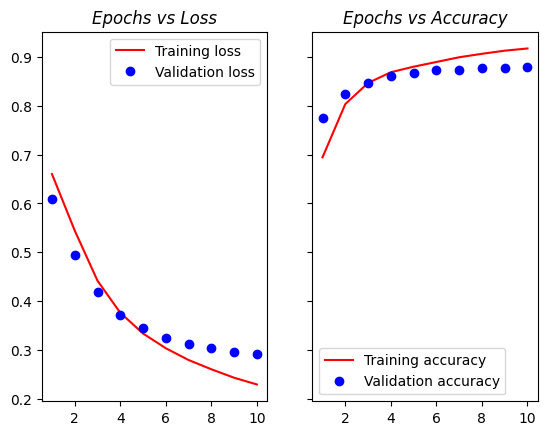

NameError: name 'end' is not defined

In [7]:
# Evaluate Embedding Model
history = model_embedding.fit(train_ds, validation_data=val_ds, epochs=epochs)

util.evaluate_model_keras(model_embedding, test_ds, history)
print(f"Training Time Embedding: {end-start}")


In [12]:
# Evaluate NLTK models
for name in performance:
    print(f'Model: {name}')
    acc = performance[name]['acc']
    time = performance[name]['time']
    auc = performance[name]['auc']
    print(f'   Accuracy: {acc}')
    print(f'   auROC: {auc}')
    print(f'   Train Time: {time}')

Model: BernoulliNB
   Accuracy: 0.654
   auROC: 0.6415503987758323
   Train Time: 0.007005453109741211
Model: ComplementNB
   Accuracy: 0.753
   auROC: 0.7557252672859608
   Train Time: 0.003006458282470703
Model: MultinomialNB
   Accuracy: 0.762
   auROC: 0.7656896558630663
   Train Time: 0.0030863285064697266
Model: KNeighborsClassifier
   Accuracy: 0.771
   auROC: 0.7729140879429898
   Train Time: 0.003000020980834961
Model: DecisionTreeClassifier
   Accuracy: 0.738
   auROC: 0.7383061140286573
   Train Time: 0.00600123405456543
Model: RandomForestClassifier
   Accuracy: 0.77
   auROC: 0.7717223670980896
   Train Time: 0.2440187931060791
Model: LogisticRegression
   Accuracy: 0.818
   auROC: 0.8204767684536469
   Train Time: 0.0070612430572509766
Model: MLPClassifier
   Accuracy: 0.812
   auROC: 0.8143919820220398
   Train Time: 1.7031054496765137
Model: AdaBoostClassifier
   Accuracy: 0.793
   auROC: 0.796011440520111
   Train Time: 0.07799911499023438


Accuracy:  0.50012
